In [1]:
from EDA import *

from unidecode import unidecode

## Importação dos dados de Maturidade dos municípios da plataforma inteli.gente (MCTI)

Plataforma do Ministério da Ciência, Tecnologia e Inovação (MCTI) que define cidades inteligentes como:

"... **cidades comprometidas com o desenvolvimento urbano sustentável e a transformação digital**, em seus aspectos econômico, meio ambiente, sociocultural e de capacidade institucional, ... e **utilizam tecnologias para solucionar problemas concretos, criar oportunidades, oferecer serviços com eficiência, reduzir desigualdades,** aumentar a resiliência **e melhorar a qualidade de vida de todas as pessoas**, garantindo o **uso seguro e responsável de dados** e das tecnologias da informação e comunicação.**"

<br><br>

<img src="imgs/art_dimensoes.png" alt="Sample Plot" width="1000"/>

**fonte:** https://inteligente.mcti.gov.br/

In [2]:
df_maturidade = pd.read_csv('data_entrega/data_raw/maturidade.csv')

# Divide coluna identificadora em município & estado (uf)
df_maturidade[['municipio', 'uf']] = df_maturidade['nome'].str.split(r' \(', expand = True)
df_maturidade['uf'] = df_maturidade['uf'].str.replace(')', '')
df_maturidade['municipio'] = df_maturidade['municipio'].str.upper().apply(unidecode)
df_maturidade['regiao'] = df_maturidade['uf'].map(brazil_regions)

df_maturidade.rename(columns = {'codigo': 'CD_MUN'}, inplace = True)

# Seleciona colunas
df_maturidade = df_maturidade[['CD_MUN', 'municipio', 'uf', 'regiao', 'latitude', 'longitude',
                               'Nivel Sociocultural', 'Nivel Economica',
                               'Nivel Capacidades Institucionais', 'Nivel Meio Ambiente',
                               'PIB per capita do municipio', 'PIB Serviços', 'PIB Industria',
                               'PIB Adminstração Publica', 'PIB Agropecuária', 'Populacao Estimada',
                               'População ocupada com vinculo formal']]

# Padronização nome colunas
df_maturidade.rename(columns = {
    'codigo': 'CD_MUN',
    'municipio': 'NM_MUN',
    'uf': 'SG_UF',
    'Nivel Sociocultural': 'NV_Sociocultural',
    'Nivel Economica': 'NV_Economico',
    'Nivel Capacidades Institucionais': 'NV_Institucional',
    'Nivel Meio Ambiente': 'NV_Ambiental',
    'PIB per capita do municipio': 'PIB_PC',
    'PIB Serviços': 'PIB_Servicos',
    'PIB Industria': 'PIB_Industria',
    'PIB Adminstração Publica': 'PIB_Administracao',
    'PIB Agropecuária': 'PIB_Agro',
    'Populacao Estimada': 'Populacao',
    'População ocupada com vinculo formal': 'Populacao_ocupada'},
    inplace = True)

df_maturidade.head()

,CD_MUN,NM_MUN,SG_UF,regiao,latitude,longitude,NV_Sociocultural,NV_Economico,NV_Institucional,NV_Ambiental,PIB_PC,PIB_Servicos,PIB_Industria,PIB_Administracao,PIB_Agro,Populacao,Populacao_ocupada
0,5200050,ABADIA DE GOIAS,GO,CENTRO-OESTE,-16.75730,-49.4412,3,4,2,4,38622.00,155667.0,79642.0,60642.0,14324.0,19128.0,1703.0
1,3100104,ABADIA DOS DOURADOS,MG,SUDESTE,-18.48310,-47.3916,3,3,2,2,25174.26,43394.0,10618.0,38588.0,75110.0,6272.0,1342.0
2,5200100,ABADIANIA,GO,CENTRO-OESTE,-16.19700,-48.7057,3,4,3,3,21334.94,168151.0,56944.0,93456.0,81207.0,17232.0,2823.0
3,3100203,ABAETE,MG,SUDESTE,-19.15510,-45.4444,4,4,2,2,23266.10,220438.0,40612.0,108971.0,127033.0,22675.0,5884.0
4,1500107,ABAETETUBA,PA,NORTE,-1.72183,-48.8788,3,4,2,2,12150.04,754254.0,73666.0,670593.0,272103.0,158188.0,16450.0


In [3]:
# Verificação de valores faltantes

## São verificados 404 valores faltantes na feature "df_maturidade.isna().sum()"
## É feita a imputação de valores faltantes é feita com a mediana obtida quando
## os dados sao agrupados de acordo com a região e o tamanho da população (cidade de mesma região e porte)
df_maturidade.isna().sum()[df_maturidade.isna().sum() > 0]

Populacao_ocupada    404
dtype: int64

In [4]:
# Imputação valores faltantes

# PIB per capita bins
pibpc_bins = [0, 12500, 25000, 40000, float('inf')]
pibpc_labels = [f'0-{pibpc_bins[1]}', f'{pibpc_bins[1]}-{pibpc_bins[2]}', f'{pibpc_bins[2]}-{pibpc_bins[3]}',
                f'{pibpc_bins[3]}+']
# Population bins
population_bins = [0, 10000, 150000, float('inf')]
population_labels = [f'0-{population_bins[1]}', f'{population_bins[1]}-{population_bins[2]}', f'{population_bins[2]}+']

df_maturidade = create_bins(df_maturidade, 'PIB_PC', 'PIBpc_bins', pibpc_bins, pibpc_labels)
df_maturidade = create_bins(df_maturidade, 'Populacao', 'Populacao_bins', population_bins, population_labels)

median_pop_reg = df_maturidade[['regiao', 'Populacao_bins', 'Populacao_ocupada']].groupby(['regiao', 'Populacao_bins'],
                                                                                          observed = True).median().reset_index()
median_pop_reg.rename(columns = {'Populacao_ocupada': 'Mediana_PopOcup'}, inplace = True)

df_maturidade = pd.merge(df_maturidade, median_pop_reg, how = 'left', on = ['regiao', 'Populacao_bins'])

df_maturidade['Populacao_ocupada'] = df_maturidade['Populacao_ocupada'].fillna(df_maturidade['Mediana_PopOcup'])
df_maturidade = df_maturidade.drop(columns = 'Mediana_PopOcup')

# Calcula porcentagem de população com ocupação laboral
df_maturidade['Ocupacao_populacao'] = df_maturidade['Populacao_ocupada'] / df_maturidade[
    'Populacao']

# Occupancy bins
occupancy_bins = [0, 0.15, .40, 1]
occupancy_labels = [f'0-{occupancy_bins[1]}', f'{occupancy_bins[1]}-{occupancy_bins[2]}', f'{occupancy_bins[2]}+']

df_maturidade = create_bins(df_maturidade, 'Ocupacao_populacao', 'Ocupacao_bins', occupancy_bins, occupancy_labels)

df_maturidade.to_pickle('data_entrega/data_clean/Maturidade.pkl')

df_maturidade.head()

,CD_MUN,NM_MUN,SG_UF,regiao,latitude,longitude,NV_Sociocultural,NV_Economico,NV_Institucional,NV_Ambiental,...,PIB_Servicos,PIB_Industria,PIB_Administracao,PIB_Agro,Populacao,Populacao_ocupada,PIBpc_bins,Populacao_bins,Ocupacao_populacao,Ocupacao_bins
0,5200050,ABADIA DE GOIAS,GO,CENTRO-OESTE,-16.75730,-49.4412,3,4,2,4,...,155667.0,79642.0,60642.0,14324.0,19128.0,1703.0,25000-40000,10000-150000,0.089032,0-0.15
1,3100104,ABADIA DOS DOURADOS,MG,SUDESTE,-18.48310,-47.3916,3,3,2,2,...,43394.0,10618.0,38588.0,75110.0,6272.0,1342.0,25000-40000,0-10000,0.213967,0.15-0.4
2,5200100,ABADIANIA,GO,CENTRO-OESTE,-16.19700,-48.7057,3,4,3,3,...,168151.0,56944.0,93456.0,81207.0,17232.0,2823.0,12500-25000,10000-150000,0.163823,0.15-0.4
3,3100203,ABAETE,MG,SUDESTE,-19.15510,-45.4444,4,4,2,2,...,220438.0,40612.0,108971.0,127033.0,22675.0,5884.0,12500-25000,10000-150000,0.259493,0.15-0.4
4,1500107,ABAETETUBA,PA,NORTE,-1.72183,-48.8788,3,4,2,2,...,754254.0,73666.0,670593.0,272103.0,158188.0,16450.0,0-12500,150000+,0.103990,0-0.15


## Inclusão dados geográficos

In [5]:
ibge_geo = pd.read_csv('data_entrega/data_raw/geodata/regioes_geograficas.csv').rename(columns = {'CD_GEOCODI': 'CD_MUN'})

df_maturidade = pd.merge(df_maturidade, ibge_geo[['CD_MUN', 'cod_rgi', 'cod_rgint']],
                         how = 'inner', on = 'CD_MUN')

brazil_map = gpd.read_file("data_entrega/data_raw/geodata/BR_Municipios_2021.shp")

brazil_map['CD_MUN'] = brazil_map['CD_MUN'].astype(float)
brazil_map['regiao'] = brazil_map['SIGLA'].map(brazil_regions)
brazil_map['reg_color'] = brazil_map['regiao'].map(REG_COLOR)
brazil_map.rename(columns = {'SIGLA': 'SG_UF'}, inplace = True)

df_spatial = pd.merge(brazil_map.drop(columns = ['NM_MUN', 'SG_UF', 'regiao']), df_maturidade,
                      how = 'left', on = 'CD_MUN')

df_spatial = df_spatial[['CD_MUN', 'NM_MUN', 'SG_UF', 'regiao',
                         'cod_rgi', 'cod_rgint',
                         'NV_Sociocultural', 'NV_Economico', 'NV_Institucional', 'NV_Ambiental',
                         'PIB_PC', 'PIBpc_bins', 'Populacao', 'Populacao_bins',
                         'Ocupacao_populacao', 'Ocupacao_bins',
                         'latitude', 'longitude', 'AREA_KM2', 'geometry', 'reg_color']]

df_spatial.to_pickle('data_entrega/data_clean/GeoMaturidade.pkl')

df_spatial.head()

,CD_MUN,NM_MUN,SG_UF,regiao,cod_rgi,cod_rgint,NV_Sociocultural,NV_Economico,NV_Institucional,NV_Ambiental,...,PIBpc_bins,Populacao,Populacao_bins,Ocupacao_populacao,Ocupacao_bins,latitude,longitude,AREA_KM2,geometry,reg_color
0,1100015.0,ALTA FLORESTA D'OESTE,RO,NORTE,110005.0,1102.0,3.0,3.0,3.0,2.0,...,25000-40000,21494.0,10000-150000,0.184703,0.15-0.4,-11.92830,-61.9953,7067.127,"POLYGON ((-62.19465 -11.82746, -62.19332 -11.8...",#ffb6c1
1,1100023.0,ARIQUEMES,RO,NORTE,110002.0,1101.0,4.0,4.0,4.0,4.0,...,25000-40000,96833.0,10000-150000,0.226627,0.15-0.4,-9.90571,-63.0325,4426.571,"POLYGON ((-62.53648 -9.73222, -62.52765 -9.736...",#ffb6c1
2,1100031.0,CABIXI,RO,NORTE,110006.0,1102.0,3.0,3.0,2.0,2.0,...,40000+,5351.0,0-10000,0.191179,0.15-0.4,-13.49450,-60.5520,1314.352,"POLYGON ((-60.37119 -13.36655, -60.37134 -13.3...",#ffb6c1
3,1100049.0,CACOAL,RO,NORTE,110005.0,1102.0,4.0,4.0,2.0,3.0,...,25000-40000,86887.0,10000-150000,0.225718,0.15-0.4,-11.43430,-61.4562,3793.000,"POLYGON ((-61.0008 -11.29737, -61.00103 -11.39...",#ffb6c1
4,1100056.0,CEREJEIRAS,RO,NORTE,110006.0,1102.0,3.0,4.0,2.0,4.0,...,40000+,15890.0,10000-150000,0.223663,0.15-0.4,-13.18700,-60.8168,2783.300,"POLYGON ((-61.49976 -13.00525, -61.49809 -13.0...",#ffb6c1


## Importação dos dados de investimento público de 2023 (MF)

Os dados são obtidos via "Portal de Dados Abertos" do Governo Federal, além disso também são disponibilizados os metadados (fornecem informações adicionais sobre as features). O orgão responsável pelos dados é o Ministério da Fazenda (MF), que fornece a seguinte descrição para o conjunto de dados:

"Corresponde ao **pagamento total (despesas do exercício pagas e restos a pagar pagos) dos grupos de natureza de despesa 4 (investimentos) e 5 (inversões financeiras)**, exceto as despesas financeiras, que compõem o Orçamento Fiscal e da Seguridade Social.

**Investimentos** são despesas orçamentárias com **softwares** e com o **planejamento e a execução de obras**, inclusive com a aquisição de imóveis considerados necessários à realização destas últimas, e com a **aquisição de instalações, equipamentos e material permanente**.

**Inversões financeiras** são despesas orçamentárias com a **aquisição de imóveis ou bens de capital já em utilização**; **aquisição de títulos** representativos do capital de empresas ou entidades de qualquer espécie, já constituídas, quando a operação não importe aumento do capital; e com a constituição ou aumento do capital de empresas, além de outras despesas classificáveis neste grupo.

**Os dados são obtidos a partir de consultas junto ao Sistema Integrado de Administração Financeira do Governo Federal – SIAFI.**"

**fonte dos dados:** https://dados.gov.br/dados/conjuntos-dados/investimento-publico

**fonte metadados:** https://www.tesourotransparente.gov.br/ckan/dataset/e048826b-b6b0-4d92-9204-fd218b1f25b3/resource/91cbf16f-19e6-48e4-b059-12b7a0758d25/download/Metadados-Investimentos.pdf

In [6]:
df = pd.read_csv('data_entrega/data_raw/investimentos/Investimentos_publicos_2023.csv', encoding = 'latin1', delimiter = ';')
df.head()

,ano,mes,esfera_orcamentaria,esfera_orcamentaria_desc,orgao_maximo,orgao_maximo_desc,uo,uo_desc,grupo_despesa,grupo_despesa_desc,...,subfuncao_desc,programa,programa_desc,acao,acao_desc,regiao,uf,uf_desc,municipio,movimento_liquido_reais
0,2023,JANEIRO,1,ORCAMENTO FISCAL,1000,CAMARA DOS DEPUTADOS,1101,CAMARA DOS DEPUTADOS,4,INVESTIMENTOS,...,ACAO LEGISLATIVA,34,PROGRAMA DE GESTAO E MANUTENCAO DO PODER LEGIS...,4061,"PROCESSO LEGISLATIVO, FISCALIZACAO E REPRESENT...",CENTRO-OESTE,DF,DISTRITO FEDERAL,BRASILIA,"2.870.698,85"
1,2023,JANEIRO,1,ORCAMENTO FISCAL,1000,CAMARA DOS DEPUTADOS,1901,FUNDO ROTATIVO DA CAMARA DOS DEPUTADOS,4,INVESTIMENTOS,...,ACAO LEGISLATIVA,34,PROGRAMA DE GESTAO E MANUTENCAO DO PODER LEGIS...,4061,"PROCESSO LEGISLATIVO, FISCALIZACAO E REPRESENT...",CENTRO-OESTE,DF,DISTRITO FEDERAL,BRASILIA,"95.640,79"
2,2023,JANEIRO,1,ORCAMENTO FISCAL,2000,SENADO FEDERAL,2101,SENADO FEDERAL,4,INVESTIMENTOS,...,ACAO LEGISLATIVA,34,PROGRAMA DE GESTAO E MANUTENCAO DO PODER LEGIS...,4061,"PROCESSO LEGISLATIVO, FISCALIZACAO E REPRESENT...",CENTRO-OESTE,DF,DISTRITO FEDERAL,BRASILIA,"1.552.301,37"
3,2023,JANEIRO,1,ORCAMENTO FISCAL,2000,SENADO FEDERAL,2101,SENADO FEDERAL,4,INVESTIMENTOS,...,ACAO LEGISLATIVA,551,ATUACAO LEGISLATIVA DO SENADO FEDERAL,4061,"PROCESSO LEGISLATIVO, FISCALIZACAO E REPRESENT...",CENTRO-OESTE,DF,DISTRITO FEDERAL,BRASILIA,"259.809,35"
4,2023,JANEIRO,1,ORCAMENTO FISCAL,3000,TRIBUNAL DE CONTAS DA UNIAO,3101,TRIBUNAL DE CONTAS DA UNIAO,4,INVESTIMENTOS,...,CONTROLE EXTERNO,34,PROGRAMA DE GESTAO E MANUTENCAO DO PODER LEGIS...,4018,FISCALIZACAO DA APLICACAO DOS RECURSOS PUBLICO...,NACIONAL,'-8,SEM INFORMACAO,SEM INFORMACAO,"3.381.823,38"


In [7]:
# Verificação de valores faltantes
df.isna().sum().sum()

0

In [8]:
# Filtragem de features (removidos ano e códigos)
df = df[df.columns[~df.columns.isin(['esfera_orcamentaria', 'orgao_maximo', 'uo',
                                     'grupo_despesa', 'aplicacao', 'resultado', 'funcao',
                                     'subfuncao', 'programa', 'acao', ])]].copy()

# Conversão de tipo
# Replace characters using regex and convert to float
df['movimento_liquido_reais'] = df['movimento_liquido_reais'].str.replace(r'[.,()]', '', regex = True).str.replace(',',
                                                                                                                   '.').astype(
    float)

df['regiao'] = df['regiao'].replace('"', '')

# Padronização nome colunas
df.rename(columns = {
    'municipio': 'NM_MUN',
    'uf': 'SG_UF'},
    inplace = True)

# Inclusão do código de cidades (padrão IBGE)
df = pd.merge(df, df_maturidade[['NM_MUN', 'SG_UF', 'CD_MUN']], how = 'left',
              on = ['NM_MUN', 'SG_UF'])

## Criando categorias 'Primario' e 'Despesa' para descrever o tipo de orçamento
df.loc[:, 'Tipo_resultado'] = df['resultado_desc'].apply(lambda x: 'Primario' if 'PRIM' in x else 'Despesa')

## Mapeamento de meses para valores ordinais
mes_to_num = {
    'JANEIRO': 1, 'FEVEREIRO': 2, 'MARCO': 3, 'ABRIL': 4, 'MAIO': 5, 'JUNHO': 6,
    'JULHO': 7, 'AGOSTO': 8, 'SETEMBRO': 9, 'OUTUBRO': 10, 'NOVEMBRO': 11, 'DEZEMBRO': 12
    }

df['mes_num'] = df['mes'].map(mes_to_num)

df.head()

,ano,mes,esfera_orcamentaria_desc,orgao_maximo_desc,uo_desc,grupo_despesa_desc,aplicacao_desc,resultado_desc,funcao_desc,subfuncao_desc,programa_desc,acao_desc,regiao,SG_UF,uf_desc,NM_MUN,movimento_liquido_reais,CD_MUN,Tipo_resultado,mes_num
0,2023,JANEIRO,ORCAMENTO FISCAL,CAMARA DOS DEPUTADOS,CAMARA DOS DEPUTADOS,INVESTIMENTOS,APLICACOES DIRETAS,PRIMARIO DISCRICIONARIO,LEGISLATIVA,ACAO LEGISLATIVA,PROGRAMA DE GESTAO E MANUTENCAO DO PODER LEGIS...,"PROCESSO LEGISLATIVO, FISCALIZACAO E REPRESENT...",CENTRO-OESTE,DF,DISTRITO FEDERAL,BRASILIA,287069885.0,5300108.0,Primario,1
1,2023,JANEIRO,ORCAMENTO FISCAL,CAMARA DOS DEPUTADOS,FUNDO ROTATIVO DA CAMARA DOS DEPUTADOS,INVESTIMENTOS,APLICACOES DIRETAS,PRIMARIO DISCRICIONARIO,LEGISLATIVA,ACAO LEGISLATIVA,PROGRAMA DE GESTAO E MANUTENCAO DO PODER LEGIS...,"PROCESSO LEGISLATIVO, FISCALIZACAO E REPRESENT...",CENTRO-OESTE,DF,DISTRITO FEDERAL,BRASILIA,9564079.0,5300108.0,Primario,1
2,2023,JANEIRO,ORCAMENTO FISCAL,SENADO FEDERAL,SENADO FEDERAL,INVESTIMENTOS,APLICACOES DIRETAS,PRIMARIO DISCRICIONARIO,LEGISLATIVA,ACAO LEGISLATIVA,PROGRAMA DE GESTAO E MANUTENCAO DO PODER LEGIS...,"PROCESSO LEGISLATIVO, FISCALIZACAO E REPRESENT...",CENTRO-OESTE,DF,DISTRITO FEDERAL,BRASILIA,155230137.0,5300108.0,Primario,1
3,2023,JANEIRO,ORCAMENTO FISCAL,SENADO FEDERAL,SENADO FEDERAL,INVESTIMENTOS,APLICACOES DIRETAS,PRIMARIO DISCRICIONARIO,LEGISLATIVA,ACAO LEGISLATIVA,ATUACAO LEGISLATIVA DO SENADO FEDERAL,"PROCESSO LEGISLATIVO, FISCALIZACAO E REPRESENT...",CENTRO-OESTE,DF,DISTRITO FEDERAL,BRASILIA,25980935.0,5300108.0,Primario,1
4,2023,JANEIRO,ORCAMENTO FISCAL,TRIBUNAL DE CONTAS DA UNIAO,TRIBUNAL DE CONTAS DA UNIAO,INVESTIMENTOS,APLICACOES DIRETAS,PRIMARIO DISCRICIONARIO,LEGISLATIVA,CONTROLE EXTERNO,PROGRAMA DE GESTAO E MANUTENCAO DO PODER LEGIS...,FISCALIZACAO DA APLICACAO DOS RECURSOS PUBLICO...,NACIONAL,'-8,SEM INFORMACAO,SEM INFORMACAO,338182338.0,NaN,Primario,1


## Exploração das variáveis categóricas

As definições dos termos técnicos são obtidos no site do Congresso Federal. Em primeiro momento é feito o delineamento de escopo, selecionando alguns dos casos para análise. Posteriormente outras dimensões dos dados estudados poderão ser incorporadas.

**fonte:** https://www.congressonacional.leg.br/legislacao-e-publicacoes/glossario-orcamentario/

## Definição de escopo através das proporções das categorias

In [9]:
# Tipo de orçamento
## Decisão de projeto: focar inicialmente no Orçamento fiscal - isso permitirá verificar se o nível de investimento em orgãos públicos terá relação direta com o nível de maturidade do município.

'''
Orçamento fiscal: Parcela do orçamento que compreende as dotações referentes aos Poderes da União, seus fundos, órgãos e entidades da administração direta e indireta, inclusive fundações instituídas e mantidas pelo Poder Público, excluindo-se as dotações destinadas à seguridade social e as relativas aos investimentos das estatais não dependentes.

Orçamento da Seguridade Social: Parcela do orçamento que abrange todas as dotações referentes às ações de saúde, previdência e assistência social das entidades e órgãos da administração direta ou indireta, bem como os fundos e fundações instituídos e mantidos pelo Poder Público.
'''

get_ratios(df, 'esfera_orcamentaria_desc')

,Feature's unique values,Ratio (%)
0,ORCAMENTO DE SEGURIDADE SOCIAL,15.55
1,ORCAMENTO FISCAL,84.45


In [10]:
# Grupo Despesa
## Decisão de projeto: focar inicialmente em Investimentos - devido à natureza da destinação de recursos (softwares, obras, instalações, equipamentos, etc).

get_ratios(df, 'grupo_despesa_desc')

,Feature's unique values,Ratio (%)
0,INVERSOES FINANCEIRAS,0.37
1,INVESTIMENTOS,99.63


In [11]:
# Resultado primário
## Decisão de projeto: focar inicialmente em resultado primário e despesa no geral - um estudo sobre as despesas poderá ser realizado, talvez considerando o tipo de emenda (despesas) e a obrigatoriedade (primário).


'''
Discricionário: cuja execução está sujeita à avaliação de oportunidade pelo gestor.

Resultado Primário: Diferença entre receitas primárias e despesas primárias. Configura-se deficit primário se o resultado for negativo, ou superavit primário, se positivo.
'''

display(get_ratios(df, 'resultado_desc'))

## Apesar de Despesa ser ~60% dos casos e primário ~40%
display(get_ratios(df, 'Tipo_resultado'))

## Primário tem 3x mais volume que despesas de movimento de recursos
df[['Tipo_resultado', 'movimento_liquido_reais']].groupby('Tipo_resultado').sum()

,Feature's unique values,Ratio (%)
0,"DESP.DISC.DECORRENTE DE EMENDA DIR.GERAL PLOA,...",2.23
1,"DESP.DISC.DECORRENTE DE EMENDA SF,CD E COMISSA...",0.62
2,DESPESA DISCRICIONARIA DECORRENTE DE EMENDA DE...,7.87
3,DESPESA DISCRICIONARIA DECORRENTE DE EMENDA IN...,47.69
4,PRIMARIO DISCRICIONARIO,36.97
5,PRIMARIO OBRIGATORIO,1.10
6,PRIMARIO SEM IMPACTO FISCAL,3.53


,Feature's unique values,Ratio (%)
0,Despesa,58.4
1,Primario,41.6


,movimento_liquido_reais
Tipo_resultado,
Despesa,1.892439e+12
Primario,6.254679e+12


In [12]:
# Região de aplicação
## Decisão de projeto: Não contemplar investimentos que sejam no exterior, sem informação ou a nível nacional. Uma vez que a granularidade dos indicadores de maturidade é a nível municipal, a mesma granulariadade será adotada em primeiro momento.

get_ratios(df, 'regiao')

,Feature's unique values,Ratio (%)
0,CENTRO-OESTE,8.63
1,EXTERIOR,0.20
2,NACIONAL,24.91
3,NORDESTE,24.46
4,NORTE,13.16
5,SEM INFORMACAO,0.02
6,SUDESTE,18.58
7,SUL,10.03


In [13]:
# Aplicando filtros de acordo com decisões de projeto

## Aplicando decisões de projeto
df_investimento = df[(df['esfera_orcamentaria_desc'] == 'ORCAMENTO FISCAL') &
                     (df['grupo_despesa_desc'] == 'INVESTIMENTOS') &
                     (~df['uf_desc'].isin(['NACIONAL', 'EXTERIOR', 'SEM INFORMACAO'])) &
                     (df['NM_MUN'] != 'SEM INFORMACAO').copy()
                     ]

## Considerando somente valores de investimentos diferentes de 0
df_investimento = df_investimento[df_investimento['movimento_liquido_reais'] != 0]

df_investimento.to_pickle('data_entrega/data_clean/df_investimento23')

df_investimento.head()

,ano,mes,esfera_orcamentaria_desc,orgao_maximo_desc,uo_desc,grupo_despesa_desc,aplicacao_desc,resultado_desc,funcao_desc,subfuncao_desc,programa_desc,acao_desc,regiao,SG_UF,uf_desc,NM_MUN,movimento_liquido_reais,CD_MUN,Tipo_resultado,mes_num
0,2023,JANEIRO,ORCAMENTO FISCAL,CAMARA DOS DEPUTADOS,CAMARA DOS DEPUTADOS,INVESTIMENTOS,APLICACOES DIRETAS,PRIMARIO DISCRICIONARIO,LEGISLATIVA,ACAO LEGISLATIVA,PROGRAMA DE GESTAO E MANUTENCAO DO PODER LEGIS...,"PROCESSO LEGISLATIVO, FISCALIZACAO E REPRESENT...",CENTRO-OESTE,DF,DISTRITO FEDERAL,BRASILIA,287069885.0,5300108.0,Primario,1
1,2023,JANEIRO,ORCAMENTO FISCAL,CAMARA DOS DEPUTADOS,FUNDO ROTATIVO DA CAMARA DOS DEPUTADOS,INVESTIMENTOS,APLICACOES DIRETAS,PRIMARIO DISCRICIONARIO,LEGISLATIVA,ACAO LEGISLATIVA,PROGRAMA DE GESTAO E MANUTENCAO DO PODER LEGIS...,"PROCESSO LEGISLATIVO, FISCALIZACAO E REPRESENT...",CENTRO-OESTE,DF,DISTRITO FEDERAL,BRASILIA,9564079.0,5300108.0,Primario,1
2,2023,JANEIRO,ORCAMENTO FISCAL,SENADO FEDERAL,SENADO FEDERAL,INVESTIMENTOS,APLICACOES DIRETAS,PRIMARIO DISCRICIONARIO,LEGISLATIVA,ACAO LEGISLATIVA,PROGRAMA DE GESTAO E MANUTENCAO DO PODER LEGIS...,"PROCESSO LEGISLATIVO, FISCALIZACAO E REPRESENT...",CENTRO-OESTE,DF,DISTRITO FEDERAL,BRASILIA,155230137.0,5300108.0,Primario,1
3,2023,JANEIRO,ORCAMENTO FISCAL,SENADO FEDERAL,SENADO FEDERAL,INVESTIMENTOS,APLICACOES DIRETAS,PRIMARIO DISCRICIONARIO,LEGISLATIVA,ACAO LEGISLATIVA,ATUACAO LEGISLATIVA DO SENADO FEDERAL,"PROCESSO LEGISLATIVO, FISCALIZACAO E REPRESENT...",CENTRO-OESTE,DF,DISTRITO FEDERAL,BRASILIA,25980935.0,5300108.0,Primario,1
5,2023,JANEIRO,ORCAMENTO FISCAL,SUPREMO TRIBUNAL FEDERAL,SUPREMO TRIBUNAL FEDERAL,INVESTIMENTOS,APLICACOES DIRETAS,PRIMARIO DISCRICIONARIO,JUDICIARIA,ACAO JUDICIARIA,PROGRAMA DE GESTAO E MANUTENCAO DO PODER JUDIC...,APRECIACAO E JULGAMENTO DE CAUSAS NO SUPREMO T...,CENTRO-OESTE,DF,DISTRITO FEDERAL,BRASILIA,10415503.0,5300108.0,Primario,1


## Integração bases Maturidade e investimentos

In [14]:
# Selecionar colunas de interesse
aux_investimento = df_investimento[['ano', 'CD_MUN', 'NM_MUN', 'SG_UF',
                                    'regiao', 'movimento_liquido_reais']]

aux_investimento = aux_investimento.groupby(aux_investimento.columns[:-1].to_list()).sum().reset_index()

# Merge e tratamento de dados necessário
df_invest_matrdd = pd.merge(df_spatial, aux_investimento,
                            how = 'left', on = aux_investimento.columns[1:-1].to_list())

## Renomear coluna e corrigir valores Nan
df_invest_matrdd.rename(columns = {'movimento_liquido_reais' : 'Investimentos_anuais'}, inplace = True)
df_invest_matrdd['Investimentos_anuais'].fillna(-1, inplace = True)
df_invest_matrdd['ano'].fillna(2023, inplace = True)

# Rearranjo conlunas e salva resultados
df_invest_matrdd = df_invest_matrdd[['ano', 'CD_MUN', 'NM_MUN', 'SG_UF', 'regiao',
       'cod_rgi', 'cod_rgint', 'Investimentos_anuais', 'NV_Sociocultural', 'NV_Economico',
       'NV_Institucional', 'NV_Ambiental', 'PIB_PC', 'PIBpc_bins', 'Populacao',
       'Populacao_bins', 'Ocupacao_populacao', 'Ocupacao_bins', 'latitude',
       'longitude', 'AREA_KM2', 'geometry', 'reg_color']]

df_invest_matrdd.to_pickle('data_entrega/data_clean/df_investimento_maturidade')

df_invest_matrdd.head()

,ano,CD_MUN,NM_MUN,SG_UF,regiao,cod_rgi,cod_rgint,Investimentos_anuais,NV_Sociocultural,NV_Economico,...,PIBpc_bins,Populacao,Populacao_bins,Ocupacao_populacao,Ocupacao_bins,latitude,longitude,AREA_KM2,geometry,reg_color
0,2023.0,1100015.0,ALTA FLORESTA D'OESTE,RO,NORTE,110005.0,1102.0,33820600.0,3.0,3.0,...,25000-40000,21494.0,10000-150000,0.184703,0.15-0.4,-11.92830,-61.9953,7067.127,"POLYGON ((-62.19465 -11.82746, -62.19332 -11.8...",#ffb6c1
1,2023.0,1100023.0,ARIQUEMES,RO,NORTE,110002.0,1101.0,295150700.0,4.0,4.0,...,25000-40000,96833.0,10000-150000,0.226627,0.15-0.4,-9.90571,-63.0325,4426.571,"POLYGON ((-62.53648 -9.73222, -62.52765 -9.736...",#ffb6c1
2,2023.0,1100031.0,CABIXI,RO,NORTE,110006.0,1102.0,35000000.0,3.0,3.0,...,40000+,5351.0,0-10000,0.191179,0.15-0.4,-13.49450,-60.5520,1314.352,"POLYGON ((-60.37119 -13.36655, -60.37134 -13.3...",#ffb6c1
3,2023.0,1100049.0,CACOAL,RO,NORTE,110005.0,1102.0,383920691.0,4.0,4.0,...,25000-40000,86887.0,10000-150000,0.225718,0.15-0.4,-11.43430,-61.4562,3793.000,"POLYGON ((-61.0008 -11.29737, -61.00103 -11.39...",#ffb6c1
4,2023.0,1100056.0,CEREJEIRAS,RO,NORTE,110006.0,1102.0,-1.0,3.0,4.0,...,40000+,15890.0,10000-150000,0.223663,0.15-0.4,-13.18700,-60.8168,2783.300,"POLYGON ((-61.49976 -13.00525, -61.49809 -13.0...",#ffb6c1


## Visualização exploratória dos dados - Dados investimento público

Possíveis análises da dimensão temporal e sua relação com o volume de recursos

- Pico em agosto, outubro e dezembro, para todas as regiões
- Após recesso parlamentar de julho?
- Datas festivas (padroeira e fim de ano)?
- Qual impacto de eleições (anos pares)?

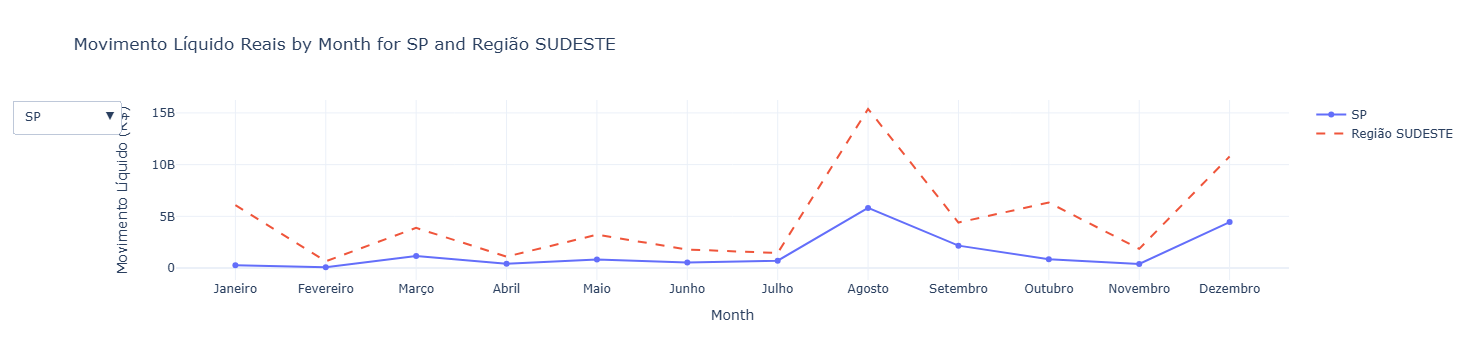

In [30]:
plot_time_serie(df_investimento, df)

## Visualização exploratória dos dados - Dados Maturidade

Valores em rosa/roxo representam o menor nível de maturidade (Adesão e Engajamento), e os verde os maiores (Alinhamento e Desenvolvimento). Focando a análise no nível economico, são feitas análises envolvendo o *tipo de aplicação do investimento* (primeira linha) e *regionalmente* (segunda linha). Para cada grupo, são selecionadas as variáveis *Movimento líquido* (montante investimento, na esquerda), *PIB per capita* (meio) e *ocupação da população* (direita).

- **Despesa primária (Movimento líquido):** Dividindo os investimentos em Primário e Despesa (definidos acima), para resultado primário as medianas são semelhantes não importando o nível de maturidade, enquanto entre despesas observa-se um padrão interessante de decaimento conforme maior nível de maturidade da cidade. *Isso pode indicar que cidade mais maduras tem melhores condições de governança pública*, porém uma investigação mais aprofundada é necessária;
- **PIB e ocupação:** Observando os casos do tipo de resultado (primeira linha), nota-se o mesmo comportamento entre níveis, não importando se Resultado primário ou despesa. Se tratando dos casos agregados regionalmente (segunda linha), observa-se que existem padrões distintos entre níveis de acordo com a região.

**Conclusão:** Foi verificado que, quando considerando PIB per capita e Ocupação da população, agrupar casos entre o tipo de resultado do investimento não produz padrões distintos. Quando analisados os *casos regionais são observados padrões distintos*, indicando que uma **análise regional é necessária** para tratar das heterogeneidades locais.

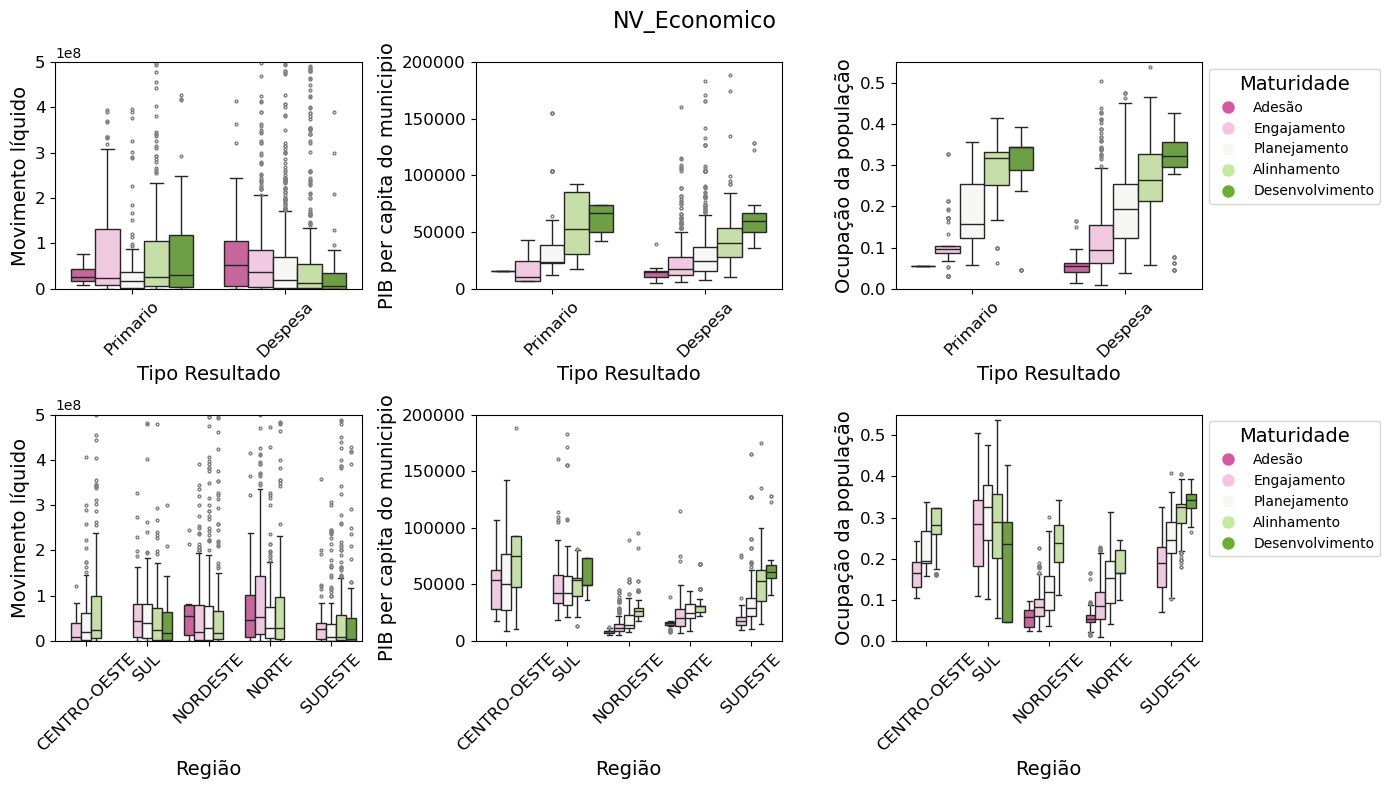

In [48]:
df_sns = pd.merge(df_investimento, df_maturidade, how = 'left', on = ['CD_MUN', 'NM_MUN', 'SG_UF', 'regiao'])
df_sns = df_sns[df_sns['movimento_liquido_reais'] > 0]

dimensoes = [idx for idx in df_sns.columns if 'NV' in idx]
plot_box(df_sns, dimensoes[1])

In [39]:
# Nível sociocultural
# plot_box(df_sns, dimensoes[0])

In [41]:
# Nível Insittucional
# plot_box(df_sns, dimensoes[2])

In [42]:
# Nível ambiental
# plot_box(df_sns, dimensoes[3])